In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [ ]:
args = {
    'batch_size': 20,
    'num_workers': 2,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 5
}

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cpu


---

In [ ]:
! wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
! unzip bike+sharing+dataset.zip

--2025-01-08 17:10:09--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip.3’

bike+sharing+datase     [ <=>                ] 273.43K  --.-KB/s    in 0.04s   

2025-01-08 17:10:09 (6.10 MB/s) - ‘bike+sharing+dataset.zip.3’ saved [279992]

Archive:  bike+sharing+dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [ ]:
! ls

bike+sharing+dataset.zip    bike+sharing+dataset.zip.2	bike_test.csv	day.csv   Readme.txt
bike+sharing+dataset.zip.1  bike+sharing+dataset.zip.3	bike_train.csv	hour.csv  sample_data


In [ ]:
df = pd.read_csv('hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

df_train.to_csv('bike_train.csv', index=False)
df_test.to_csv('bike_test.csv', index=False)

!ls

bike+sharing+dataset.zip    bike+sharing+dataset.zip.2	bike_test.csv	day.csv   Readme.txt
bike+sharing+dataset.zip.1  bike+sharing+dataset.zip.3	bike_train.csv	hour.csv  sample_data


In [ ]:
class Bicicreta(Dataset):
    def __init__(self, csv_path):
        self.dados = pd.read_csv(csv_path).to_numpy()

    def __getitem__(self, idx):
        sample = self.dados[idx][2:14]
        label = self.dados[idx][-1:]

        sample = torch.from_numpy(sample.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))

        return sample, label

    def __len__(self):
        return len(self.dados)

In [ ]:
train_set = Bicicreta('bike_train.csv')
test_set = Bicicreta('bike_test.csv')

In [ ]:
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.output  = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        feature = self.features(X)
        output  = self.output(feature)
        return output

In [ ]:
input_size  = len(train_set[0][0])
hidden_size = 128
output_size = 1

In [ ]:
net = MLP(input_size, hidden_size, output_size).to(device)
print(net)

MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
def train(train_loader, net, epoch):
  net.train()

  start = time.time()

  epoch_loss  = []
  for batch in train_loader:

    dado, rotulo = batch

    dado = dado.to(device)
    rotulo = rotulo.to(device)

    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

In [ ]:
def test(test_loader, net, epoch):
  net.eval()

  start = time.time()

  epoch_loss  = []

  with torch.no_grad():
    for batch in test_loader:

      dado, rotulo = batch

      dado = dado.to(device)
      rotulo = rotulo.to(device)

      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

In [ ]:
train_losses, test_losses = [], []
for epoch in range(args['num_epochs']):

  # Train
  train_losses.append(train(train_loader, net, epoch))

  # Validate
  test_losses.append(test(test_loader, net, epoch))

#################### Train ####################
Epoch 0, Loss: 149.5431 +/- 40.7663, Time: 2.78
********** Validate **********
Epoch 0, Loss: 132.0381 +/- 21.7941, Time: 0.47

#################### Train ####################
Epoch 1, Loss: 125.1214 +/- 32.3439, Time: 2.65
********** Validate **********
Epoch 1, Loss: 114.7287 +/- 25.3082, Time: 0.46

#################### Train ####################
Epoch 2, Loss: 122.4004 +/- 29.8473, Time: 2.90
********** Validate **********
Epoch 2, Loss: 122.2157 +/- 30.7584, Time: 0.76

#################### Train ####################
Epoch 3, Loss: 117.2712 +/- 27.4822, Time: 3.60
********** Validate **********
Epoch 3, Loss: 114.4811 +/- 26.8730, Time: 0.46

#################### Train ####################
Epoch 4, Loss: 115.1293 +/- 29.1694, Time: 2.89
********** Validate **********
Epoch 4, Loss: 109.4245 +/- 23.6150, Time: 0.46



In [ ]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(device)

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,352.0,284.225983
1,156.0,219.682175
2,12.0,56.404934
3,2.0,67.671066
4,391.0,182.961258
5,391.0,340.974426
6,84.0,196.714325
7,487.0,298.189178
8,176.0,175.599670
9,157.0,183.775543


In [ ]:
train_losses

[149.54308, 125.12143, 122.40039, 117.27124, 115.12933]

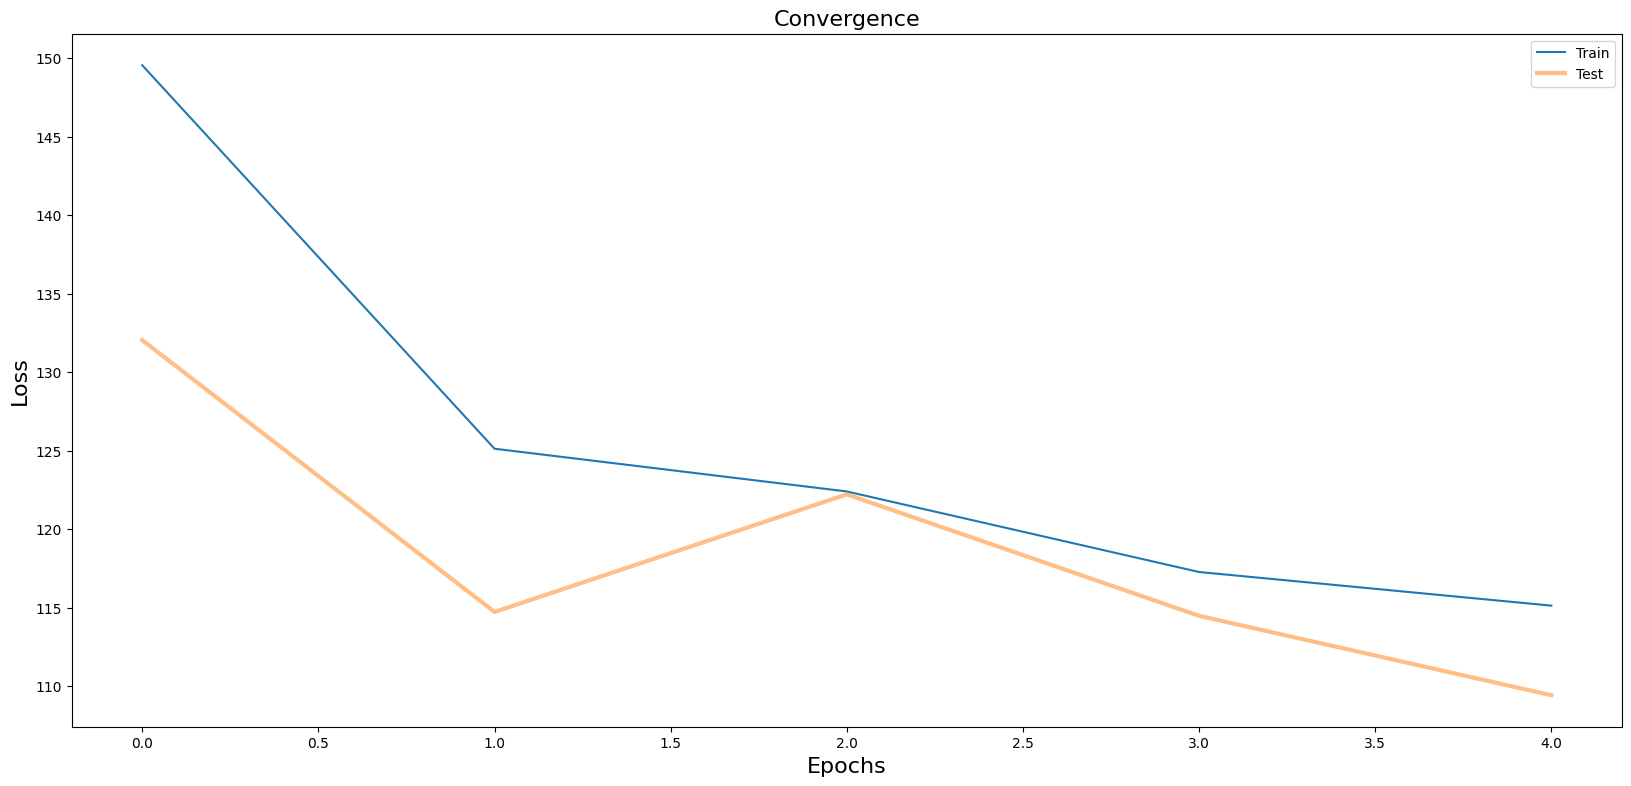

In [ ]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()

---

In [ ]:
# # Resumo do código: Função forward()
# def forward(loader, net, epoch, mode):
#   if mode == "train":
#     net.train()
#   else:
#     net.eval()

#   epoch_loss = []
#   for batch in loader:
#     dado, rotulo = batch

#     # Cast na GPU
#     dado   = dado.to(args['device'])
#     rotulo = rotulo.to(args['device'])

#     # Forward
#     pred = net(dado)
#     loss = criterion(pred, rotulo)
#     epoch_loss.append(loss.cpu().data)

#     if mode == "train":
#       # Backward
#       loss.backward()
#       optimizer.step()

#   epoch_loss = np.asarray(epoch_loss)
#   print("Epoca %d, Loss: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()) )

# # Resumo do código: Chamada de função
# for epoch in range(args['num_epochs']):
#   forward(train_loader, net, epoch, "train")
#   forward(test_loader, net, epoch, "test")
#   print("-------------------------------")